Preprocess fMRI data

In [1]:
from pathlib import Path
import pandas as pd
import nibabel as nib
import numpy as np
from typing import Dict, List
import sys
sys.path.append("/opt/animalfmritools")

from notebooks.local.preprocess.pipeline_reader import PipelineReader

Run-level preprocessing

In [2]:
denoise_settings = {
    "data_type": "nifti",
    "regressor_rules": ("mc24","csf+derivatives",),
    "n_start_volumes_to_remove": 1,
    "detrend": True,
    "standardize": "zscore_sample",
    "standardize_confounds": True,
    "filter": "butterworth",
    "low_pass": .2,
    "high_pass": .01,
    "smooth_mm": .5,
    "out_dir": Path("projects/ADPET/denoising-outputs")
}
species = "mouse"
cohort = "ADPET"
deriv_dir_base = "bold_preproc"
bids_dir = f"/data/{species}/{cohort}"
default_repetition_time = None
session_tr_changes = {}
preproc_reader = PipelineReader(bids_dir, deriv_dir_base, default_repetition_time=default_repetition_time, session_tr_changes=session_tr_changes)
dataset = preproc_reader.get_processed_data()

# Denoise data 
for subject in dataset.subjects:
    for session in subject.sessions:
        for bold_run in session.bold_runs:
            bold_data = bold_run.load_bold(**denoise_settings)

--Return--
None
> /tmp/ipykernel_763/682130810.py(14)<module>()
     12     "out_dir": Path("projects/ADPET/denoising-outputs")
     13 }
---> 14 import pdb; pdb.set_trace()
     15 species = "mouse"
     16 cohort = "ADPET"



List all bold runs

In [3]:
bolds = !ls projects/ADPET/denoising-outputs/*s-0-5_bold.nii.gz

len(bolds)

100

Tools

In [4]:
from notebooks.projects.ADPET.utils import (
    MOUSE_TEMPLATE_DIR,
    aba_setup,
    main_create_atlas,
    euclidean_distance_from_atlas,
)

import matplotlib.pyplot as plt


# Create atlas
roi_dir = aba_setup()
json_file = MOUSE_TEMPLATE_DIR / "ABA_ontology.json"
atlas_annots, atlas_nifti = main_create_atlas(json_file, roi_dir, mouse_template_dir=MOUSE_TEMPLATE_DIR)

from IPython.display import clear_output
clear_output()

Atlas dump 

In [5]:
atlas_annots_df = pd.DataFrame(
    {
        "parent_region": [i[1] for i in atlas_annots],
        "region": [i[2] for i in atlas_annots],
        "label": [i[0] for i in atlas_annots],
    }
)
atlas_annots_df.to_csv(roi_dir / f"atlas_labels.csv", index=False) # Dump atlas labels to csv
!cp {atlas_nifti} {roi_dir}/"atlas.nii.gz" # Copy atlas here

atlas_annots_df.head(5)

,parent_region,region,label
0,Isocortex,FRP_RH,1
1,Isocortex,FRP_LH,2
2,Isocortex,MOp_RH,3
3,Isocortex,MOp_LH,4
4,Isocortex,MOs_RH,5


/usr/local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


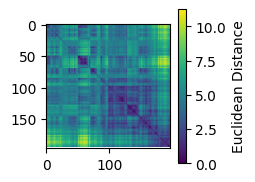

In [6]:
distance_matrix = euclidean_distance_from_atlas(atlas_nifti)

fig, ax = plt.subplots(figsize=(2,2),)
im = ax.imshow(distance_matrix)
# Add a colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Euclidean Distance')

In [8]:
TR = 1.5
SA_DISCRETIZATION = .1
metric_dir = Path("./projects/ADPET/metrics")
if not metric_dir.exists():
    metric_dir.mkdir(parents=True)
    
RSFC_CSV = metric_dir / "rsfc.csv"
TSNR_CSV = metric_dir / "tsnr.csv"
ALFF_CSV = metric_dir / "alff.csv"
FALFF_CSV = metric_dir / "falff.csv"
TA_LAG_1_CSV = metric_dir / "ta_lag_1.csv"
GLOBAL_SA_LAMBDA_CSV = metric_dir / "global_sa_lambda.csv"
GLOBAL_SA_INF_CSV = metric_dir / "global_sa_inf.csv"
GLOBAL_TA_LAG_1_CSV = metric_dir / "global_ta_lag_1.csv"
SUBJECTS_CSV = metric_dir / "subjects.csv"
LABELS_CSV = metric_dir / "labels.csv"
ROI_PAIRS_CSV = metric_dir / "roi_pairs.csv"

In [9]:
import warnings
warnings.filterwarnings("ignore")

from notebooks.projects.ADPET.utils import (
    check_labels_in_atlas,
    calculate_all_metrics
)

def csv_not_filled(csv_files: List[Path]) -> bool:
    return any(not csv_file.exists() for csv_file in csv_files)

if csv_not_filled([RSFC_CSV, TSNR_CSV, ALFF_CSV, FALFF_CSV, TA_LAG_1_CSV, GLOBAL_TA_LAG_1_CSV, GLOBAL_SA_LAMBDA_CSV, GLOBAL_SA_INF_CSV, SUBJECTS_CSV, LABELS_CSV, ROI_PAIRS_CSV]):
    # Save connectivity values as csv
    first_check = True
    subject_run_labels = []
    tsnr_data = []
    alff_data = []
    falff_data = []
    ta_lag_1_data = []
    global_sa_lambda_data = []
    global_sa_inf_data = []
    global_ta_lag_1_data = []
    with open(RSFC_CSV, 'w') as f:
        
        for bold_ix, bold in enumerate(bolds):

            bold = Path(bold)
            print(bold_ix, bold.stem)
            sub_id = bold.stem.split('sub-')[1].split('_')[0]
            ses_id = bold.stem.split('ses-')[1].split('_')[0]
            run_id = bold.stem.split('run-')[1].split('_')[0]
            subject_run_labels.append(f"sub-{sub_id}_ses-{ses_id}_run-{run_id}")
        
            resliced_atlas_path = Path(f"/tmp/sub-{sub_id}_ses-{ses_id}_atlas.nii.gz")
            
            
            # Reslice atlas to subject's templace space
            if not resliced_atlas_path.exists():
                #print(f"Reference: {bold.stem}")
                !flirt -in {atlas_nifti} -ref {bold} -out {resliced_atlas_path} -interp nearestneighbour -applyxfm -usesqform
        
            if run_id == '01':
                #print(resliced_atlas_path)
                check_labels_in_atlas(atlas_annots, resliced_atlas_path)
            # Calculate metrics
            metric_dict = calculate_all_metrics(
                bold, 
                resliced_atlas_path, 
                atlas_annots, 
                TR, 
                distance_matrix,
                SA_DISCRETIZATION,
            )
            # Get label-to-label information from the connectivity matrix
            if first_check:
                pair_rois = [i for i in metric_dict["rsfc"].keys()]
                first_check = False
            
            pair_C = [str(i) for i in metric_dict["rsfc"].values()]
            assert len(pair_rois) == len(pair_C)
            f.write(','.join(pair_C))
            f.write('\n')
            # Store labels per metric to list
            tsnr_data.append(metric_dict["tsnr"])
            alff_data.append(metric_dict["alff"])
            falff_data.append(metric_dict["falff"])
            ta_lag_1_data.append(metric_dict["ta_lag_1"])
            global_sa_inf_data.append(metric_dict["global_sa_inf"])
            global_sa_lambda_data.append(metric_dict["global_sa_lambda"])
            global_ta_lag_1_data.append(metric_dict["global_ta_lag_1"])

            !rm {resliced_atlas_path}

    # Save tsnr data with columns corresponding to rois from `labels`
    with open(TSNR_CSV, "w") as f:
        for i in tsnr_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save alff data with columns corresponding to rois from `labels`
    with open(ALFF_CSV, "w") as f:
        for i in alff_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save falff data with columns corresponding to rois from `labels`
    with open(FALFF_CSV, "w") as f:
        for i in falff_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save ta_lag_1 data with columns corresponding to rois from `labels`
    with open(TA_LAG_1_CSV, "w") as f:
        for i in ta_lag_1_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save global_sa_lambda data (1 measure per dataset, rows denote different subjects)
    with open(GLOBAL_SA_LAMBDA_CSV, "w") as f:
        for i in global_sa_lambda_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save global_sa_inf data (1 measure per dataset, rows denote different subjects)
    with open(GLOBAL_SA_INF_CSV, "w") as f:
        for i in global_sa_inf_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save global_ta_lag_1 data (1 measure per dataset, rows denote different subjects)
    with open(GLOBAL_TA_LAG_1_CSV, "w") as f:
        for i in global_ta_lag_1_data:
            f.write(str(i)[1:-1].replace(' ',''))
            f.write('\n')
    # Save subject info as rows in a csv - this corresponds to rows of the RSFC CSV (also rows of calculated metrics)
    with open(SUBJECTS_CSV, "w") as f:
        for i in subject_run_labels:
            f.write(i)
            f.write('\n')
    # Save roi labels as rows in a csv - this corresponds to rows of metrics (i.e., tsnr, alff, falff, ta_lag_1)
    with open(LABELS_CSV, "w") as f:
        for i in metric_dict["labels"]:
            f.write(i)
            f.write('\n')
    # Save roi pair infos as rows in a csv - this corresponds to columns of the RSFC CSV
    with open(ROI_PAIRS_CSV, 'w') as f:
        for ix, i in enumerate(pair_rois):
            f.write(i)
            f.write('\n')

0 sub-AppKI1hTauApoE3202F4_ses-01_task-rest_dir-AP_run-01_space-template_desc-preproc_desc-denoised_s-0-5_bold.nii
[WARNING] DORsm_LH [100] not in atlas.
[WARNING] VENT_RH [101] not in atlas.
[WARNING] VENT_LH [102] not in atlas.
[WARNING] VP_RH [103] not in atlas.
[WARNING] VP_LH [104] not in atlas.
[WARNING] SPF_RH [105] not in atlas.
[WARNING] SPF_LH [106] not in atlas.
[WARNING] MG_RH [107] not in atlas.
[WARNING] MG_LH [108] not in atlas.
[WARNING] LGd_RH [109] not in atlas.
[WARNING] LGd_LH [110] not in atlas.
[WARNING] DORpm_RH [111] not in atlas.
[WARNING] DORpm_LH [112] not in atlas.
[WARNING] LAT_RH [113] not in atlas.
[WARNING] LAT_LH [114] not in atlas.
[WARNING] ATN_RH [115] not in atlas.
[WARNING] ATN_LH [116] not in atlas.
[WARNING] AM_RH [117] not in atlas.
[WARNING] AM_LH [118] not in atlas.
[WARNING] MED_RH [119] not in atlas.
[WARNING] MED_LH [120] not in atlas.
[WARNING] MTN_RH [121] not in atlas.
[WARNING] MTN_LH [122] not in atlas.
[WARNING] ILM_RH [123] not in at

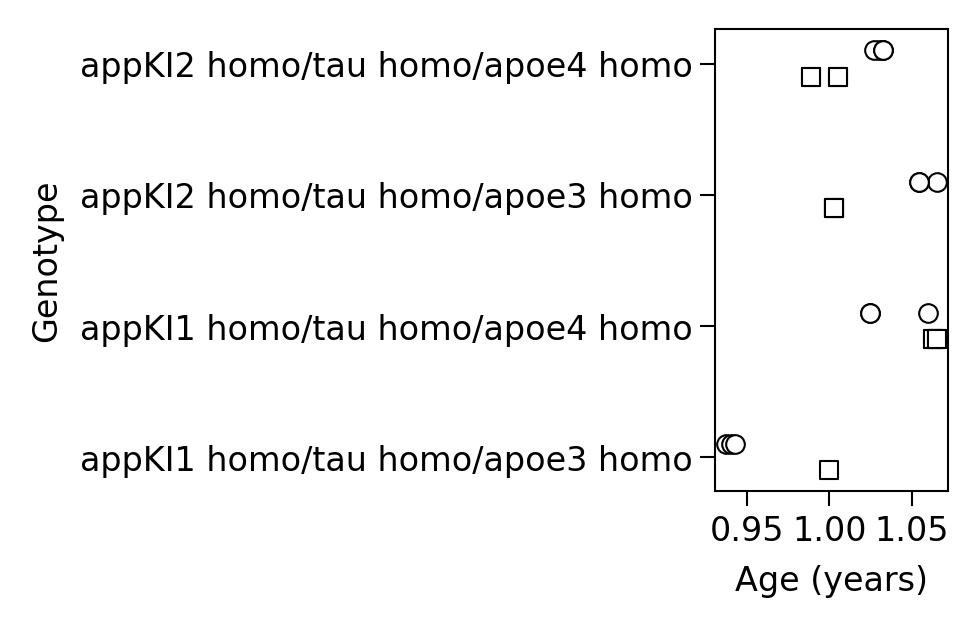

In [10]:

LW=.5
FONTSIZE=8

participants_df = pd.read_csv("/data/mouse/ADPET/ADPET_participants.csv")
"""Filter columns
"""
keep_cols = ["mri_id","ses_id","genotype","sex","birthday","mri_scan_date"]
participants_df = participants_df[keep_cols]
"""Filter our subjects who did not have MRI scans - 
    - 2/3 were removed due to tail issue
"""
participants_df = participants_df[~(participants_df.mri_id.isna())]
"""Converts date to age in years
"""
from datetime import datetime
def calculate_age_at_mri(birth_date,mri_date):
    birth_date = datetime.strptime(birth_date,"%m/%d/%Y")
    mri_date = datetime.strptime(mri_date,"%m/%d/%Y")
    difference_in_days = (mri_date - birth_date).days
    age_in_years = difference_in_days / 365

    if age_in_years <= 0:
        raise ValueError(f"{age_in_years} is negative or zero.")

    return age_in_years
    
participants_df["age"] = participants_df.apply(
    lambda row: calculate_age_at_mri(
        row["birthday"],
        row["mri_scan_date"]
    ), 
    axis=1
)
participants_df = participants_df.drop(["birthday","mri_scan_date"],axis=1)

participants_df["APOE"] = participants_df.genotype.str.split("apoe").str[-1].str.split(" ").str[0]
participants_df["AppKI"] = participants_df.genotype.str.split("appKI").str[-1].str.split(" ").str[0]

fig, ax = plt.subplots(figsize=(1,2),dpi=300)
ylabels = []
for ix,genotype in enumerate(participants_df.genotype.unique()):
    ylabels.append(genotype)
    male_df = participants_df[(participants_df.genotype==genotype) & (participants_df.sex=="M")]
    female_df = participants_df[(participants_df.genotype==genotype) & (participants_df.sex=="F")]
    for sex_ix, (_df,markerstyle) in enumerate(zip([male_df,female_df],["s","o"])):
        age = _df.age
        ax.scatter(age,np.zeros_like(age)+ix+(sex_ix*.2),marker=markerstyle,c='white',edgecolor='k',linewidths=LW,s=20)
ax.set_yticks([i+.1 for i in range(4)])
ax.set_yticklabels(ylabels,fontsize=FONTSIZE,rotation=0)
ax.set_ylabel("Genotype",fontsize=FONTSIZE)
ax.set_xlabel("Age (years)",fontsize=FONTSIZE)

ax.tick_params("both",labelsize=FONTSIZE,pad=2,width=LW)
for _spine in ["left","right","top","bottom"]:
    ax.spines[_spine].set_linewidth(LW)

In [11]:
participants_df.head(5)

,mri_id,ses_id,genotype,sex,age,APOE,AppKI
0,AppKI1hTauApoE3202F4,1.0,appKI1 homo/tau homo/apoe3 homo,F,0.936986,3,1
1,AppKI1hTauApoE3202F5,1.0,appKI1 homo/tau homo/apoe3 homo,F,0.939726,3,1
2,AppKI1hTauApoE3213F1,1.0,appKI1 homo/tau homo/apoe3 homo,F,0.942466,3,1
3,AppKI1hTauApoE4261F1,1.0,appKI1 homo/tau homo/apoe4 homo,F,1.024658,4,1
4,AppKI1hTauApoE4261F2,1.0,appKI1 homo/tau homo/apoe4 homo,F,1.024658,4,1


In [12]:

def csv_to_df(data_csv, col_csv, row_csv, participants_df):
    # Load csvs as a dataframe
    col_labels = pd.read_csv(col_csv, header = None).iloc[:,0].values.tolist()
    row_csv = pd.read_csv(row_csv,header = None).iloc[:,0].values.tolist()
    data_df = pd.read_csv(data_csv, header=None)
    if data_df.shape[-1] != 1:
        data_df.columns = col_labels # Load column info
    data_df.index = row_csv # Load row info
    # Load project, genotype, and sex info into data_df
    genotype_ids, sex_ids, apoe_ids, appki_ids = [], [], [], []
    for row in data_df.index:
        sub_id = row.split('sub-')[-1].split('_')[0]
        ses_id = int(row.split('ses-')[-1].split('_')[0])
        sub_info = participants_df[(participants_df['mri_id'] == sub_id) & (participants_df['ses_id'] == ses_id)]
        assert sub_info.shape[0] == 1, print(f"[{sub_info.shape[0]}] row(s) detected. Expected 1.")
        genotype_ids.append(sub_info.genotype.values[0])
        sex_ids.append(sub_info.sex.values[0])
        apoe_ids.append(sub_info.APOE.values[0])
        appki_ids.append(sub_info.AppKI.values[0])
    data_df['genotype_id'] = genotype_ids
    data_df['gender'] = sex_ids
    data_df["APOE"] = apoe_ids
    data_df["AppKI"] = appki_ids

    # Decompress index into data_df.columns
    # Add sub_id, ses_id, and run_id columns
    data_df = data_df.reset_index()
    data_df[["sub_id", "ses_id", "run_id"]] = data_df['index'].str.split("_", expand=True)
    data_df = data_df.drop(columns=['index'])
    data_df['sub_id'] = data_df['sub_id'].str.split('-').str[-1]
    data_df['ses_id'] = data_df['ses_id'].str.split('-').str[-1]
    data_df['run_id'] = data_df['run_id'].str.split('-').str[-1]
    
    return data_df

def values2conn(v, atlas_annots):
    atlas_labels = [k for i,j,k in atlas_annots]
    n_labels = len(atlas_labels)
    csv2conn = np.zeros((n_labels, n_labels))
    for i_ix, i in enumerate(atlas_labels):
        for j_ix, j in enumerate(atlas_labels):
            if i_ix == j_ix or i_ix > j_ix:
                continue
            pair_id = f"{atlas_labels[j_ix]}-{atlas_labels[i_ix]}"
            C_value = v[pair_id]
            csv2conn[j_ix, i_ix] = C_value
    
    return csv2conn

def values2heatmap_metrics(subset_df, atlas_annots, run_ids):
    atlas_labels = [k for _, _, k in atlas_annots]
    n_labels = len(atlas_labels)
    n_runs = len(run_ids)
    heatmap = np.zeros((n_labels, n_runs))
    for run_ix, run_id in enumerate(run_ids):
        run_df = subset_df[(subset_df.genotype_id==run_id)]
        n_bold = run_df.shape[0]
        print(run_id,n_bold,n_bold/4)
        run_df = run_df.apply(pd.to_numeric,errors='coerce')
        values = run_df.mean()
        for i_ix, label in enumerate(atlas_labels):
            _value = values[label]
            heatmap[i_ix, run_ix] = _value
    
    return heatmap


In [13]:
dfs = {}
for metric_type, metric_csv in zip(
    ['rsfc','tsnr','alff','falff','ta_lag_1','global_ta_lag_1','global_sa_lambda','global_sa_inf'],
    [RSFC_CSV, TSNR_CSV, ALFF_CSV, FALFF_CSV, TA_LAG_1_CSV, GLOBAL_TA_LAG_1_CSV, GLOBAL_SA_LAMBDA_CSV, GLOBAL_SA_INF_CSV],
):

    if metric_type == "rsfc":
        dfs[metric_type] = csv_to_df(metric_csv, ROI_PAIRS_CSV, SUBJECTS_CSV, participants_df)
    else:
        dfs[metric_type] = csv_to_df(metric_csv, LABELS_CSV, SUBJECTS_CSV, participants_df)

    print(dfs[metric_type].shape)

(100, 19510)
(100, 205)
(100, 205)
(100, 205)
(100, 205)
(100, 8)
(100, 8)
(100, 8)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm  # Importing the colormap module

# Inputs
genotypes = participants_df.genotype.unique()
n_genotypes = genotypes.shape[0]
# Create figure directory
fig_dir = Path("./projects/ADPET/figures")
if not fig_dir.exists():
    fig_dir.mkdir(parents=True,exist_ok=True)

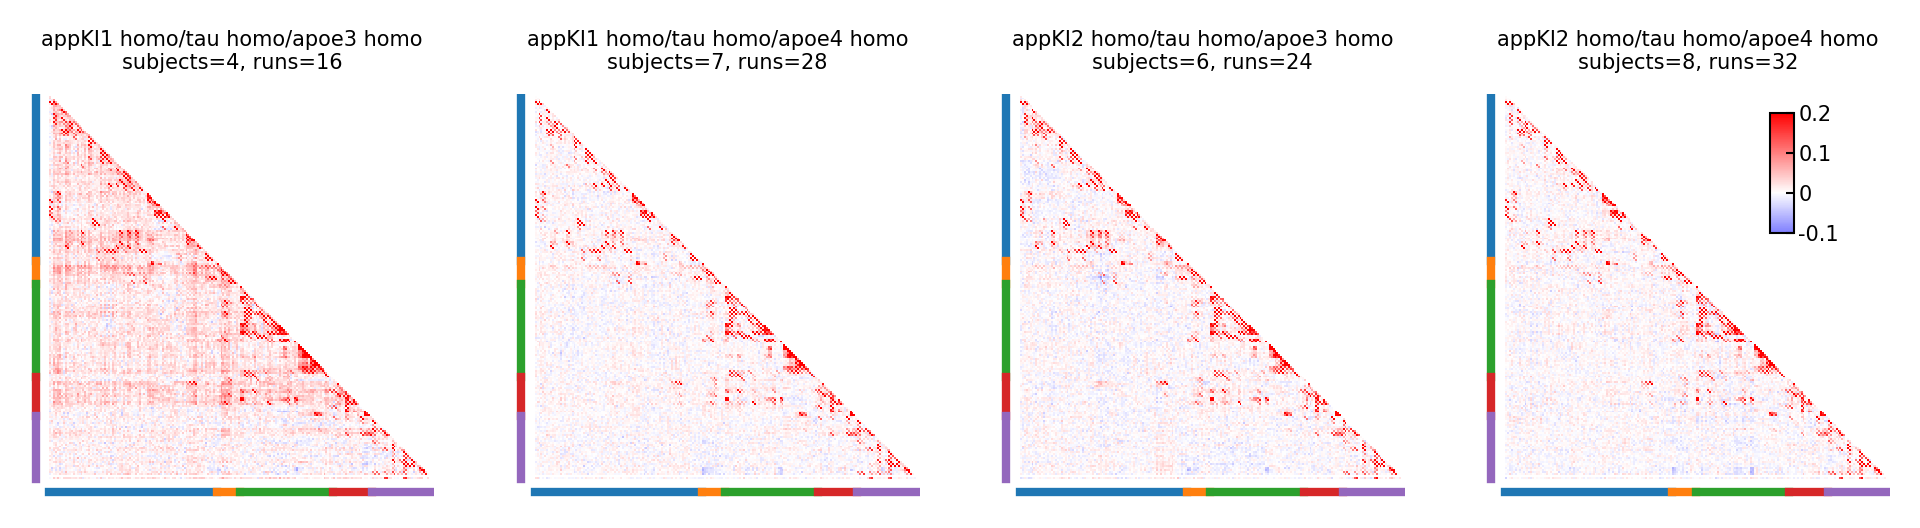

In [15]:
FONTSIZE = 5
cmap = cm.get_cmap("tab10")
ncols = 4

num_isocortex = sum([i[1]=="Isocortex" for i in atlas_annots])
num_hpf = sum([i[1]=="HPF" for i in atlas_annots])
num_interbrain = sum([i[1]=="Interbrain" for i in atlas_annots])
num_midbrain = sum([i[1]=="Midbrain" for i in atlas_annots])
num_hindbrain = sum([i[1]=="Hindbrain" for i in atlas_annots])

# figure set-up
fig, axs = plt.subplots(
    ncols=ncols,
    figsize=(ncols*2,2),
    dpi=300
)

df = dfs["rsfc"].copy()

for col_ix, genotype in enumerate(genotypes):

    subset_df = df[(df.genotype_id == genotype)]

    n_runs = subset_df.shape[0]
    n_subjects = n_runs/4
    if n_subjects % 1 == 0:
        n_subjects = int(n_subjects)
    else:
        raise ValueError(f"{n_subjects} is suppose to be an integer.Check.")
    subset_df = subset_df.apply(pd.to_numeric,errors="coerce")
    conn_values = subset_df.mean()
    conn = values2conn(conn_values, atlas_annots)
    mask = np.triu(np.ones_like(conn, dtype=bool))

    # Heatmap
    X = sns.heatmap(
        conn, 
        mask = mask, 
        cmap = 'bwr', 
        square = True, 
        linewidths = 0, 
        cbar = None,
        center = 0,
        vmax=.2,
        vmin=-.1,
        ax=axs[col_ix],
        zorder=2,
    )
    axs[col_ix].set_title(f"{genotype}\nsubjects={n_subjects}, runs={n_runs}", fontsize=FONTSIZE)
    _ = X.set_xticks([])
    _ = X.set_yticks([])

    # Tag x/y-axes
    begin_tracker = 0
    total_rois = np.array([len(atlas_annots)]).sum()
    axs[col_ix].set_xlim(-10, total_rois)
    axs[col_ix].set_ylim(total_rois+10, 0)
    for n_rois, _color in zip(
        [num_isocortex, num_hpf, num_interbrain, num_midbrain, num_hindbrain],
        [cmap(i) for i in range(5)]
    ):
        end_tracker = begin_tracker + n_rois
        axs[col_ix].plot([-7, -7],[begin_tracker, end_tracker], c=_color, lw=2., zorder=4)
        axs[col_ix].plot([begin_tracker, end_tracker], [total_rois+7, total_rois+7], c=_color, lw=2., zorder=4)
        begin_tracker = end_tracker

# Plot colorbar for the whole figure panel
# Create a new color bar on the top right corner
cax = fig.add_axes([0.85, 0.6, 0.01, 0.2])  # [left, bottom, width, height]
cbar = plt.colorbar(X.collections[0], cax=cax) 
# Add ticks and labels to the color bar
cbar.set_ticks([-.1, 0, 0.1, 0.2])  # Add custom tick positions
cbar.set_ticklabels(['-0.1', '0', '0.1', '0.2'], fontsize=FONTSIZE) 
#cbar.ax.text(.5,.5+.1, 'ρ', ha='center', va='center', fontsize=FONTSIZE)
cbar.ax.tick_params(width=.5,pad=1,direction="in",length=2)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(.5)

appKI1 homo/tau homo/apoe3 homo 16 4.0
appKI1 homo/tau homo/apoe4 homo 28 7.0
appKI2 homo/tau homo/apoe3 homo 24 6.0
appKI2 homo/tau homo/apoe4 homo 32 8.0
appKI1 homo/tau homo/apoe3 homo 16 4.0
appKI1 homo/tau homo/apoe4 homo 28 7.0
appKI2 homo/tau homo/apoe3 homo 24 6.0
appKI2 homo/tau homo/apoe4 homo 32 8.0
appKI1 homo/tau homo/apoe3 homo 16 4.0
appKI1 homo/tau homo/apoe4 homo 28 7.0
appKI2 homo/tau homo/apoe3 homo 24 6.0
appKI2 homo/tau homo/apoe4 homo 32 8.0
appKI1 homo/tau homo/apoe3 homo 16 4.0
appKI1 homo/tau homo/apoe4 homo 28 7.0
appKI2 homo/tau homo/apoe3 homo 24 6.0
appKI2 homo/tau homo/apoe4 homo 32 8.0


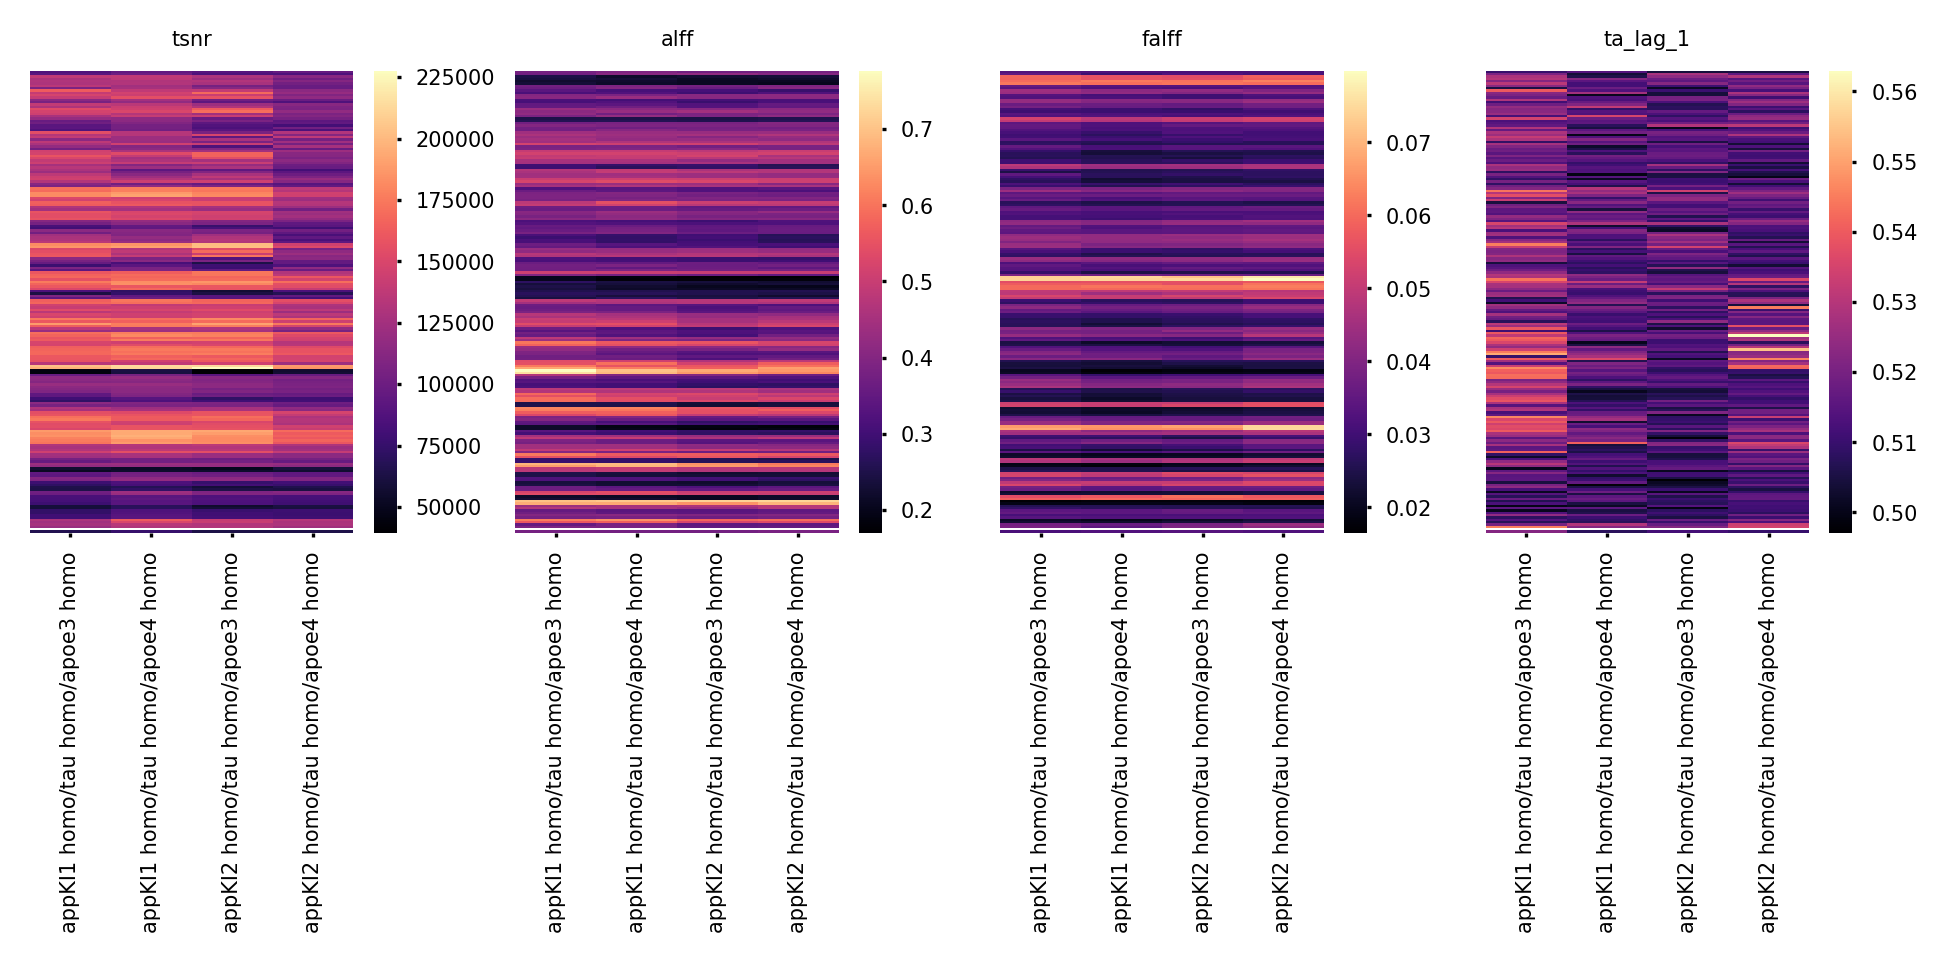

In [16]:
FONTSIZE = 5
cmap = cm.get_cmap("tab10")

ncols = 4

# figure set-up
fig, axs = plt.subplots(
    ncols=ncols,
    figsize=(ncols*2,2),
    dpi=300
)

for col_ix, metric_type in enumerate(['tsnr', 'alff', 'falff', 'ta_lag_1']):

    subset_df = dfs[metric_type].copy()

    heatmap = values2heatmap_metrics(subset_df, atlas_annots, genotypes)

    # Heatmap
    X = sns.heatmap(
        heatmap, 
        cmap = 'magma', 
        ax=axs[col_ix],
        zorder=2,
    )
    cbar = X.collections[0].colorbar  # Get the colorbar
    cbar.ax.tick_params(labelsize=FONTSIZE) 
    cbar.ax.tick_params(axis='y', length=1)
    axs[col_ix].set_title(f"{metric_type}", fontsize=FONTSIZE)
    _ = X.set_xticks([i+.5 for i in range(len(genotypes))])
    _ = X.set_xticklabels(genotypes,rotation=90,fontsize=FONTSIZE)
    _ = axs[col_ix].tick_params(axis='x', length=1)
    _ = X.set_yticks([])
    """
    # Tag x/y-axes
    begin_tracker = 0
    total_rois = np.array([len(isocortex), len(hpf), len(interbrain), len(midbrain), len(hindbrain)]).sum()
    axs[row_ix,col_ix].set_xlim(-1, len(run_ids))
    for n_rois, _color in zip(
        [len(isocortex), len(hpf), len(interbrain), len(midbrain), len(hindbrain)],
        [cmap(i) for i in range(5)]
    ):
        end_tracker = begin_tracker + n_rois
        axs[row_ix,col_ix].plot([-.5, -.5],[begin_tracker, end_tracker], c=_color, lw=3.5, zorder=4)
        begin_tracker = end_tracker
    """

# Save figure
#fig.tight_layout()
#fig.savefig(fig_dir / "regional_metrics.png", dpi= 500)

In [17]:
for metric_key in ["ta_lag_1", "rsfc", "alff", "falff","tsnr"]:
    
    # Loop over all metric dfs
    subset_df = dfs[metric_key]
        
    metric_cols = []
    var_cols = ["gender", "genotype_id", "APOE", "AppKI", "sub_id", "ses_id", "run_id"]
    for i in subset_df.columns:
        if i not in var_cols:
            metric_cols.append(i)

    new_data = {
        "sub_id": [],
        "ses_id": [],
        "run_id": [],
        "APOE": [],
        "AppKI": [],
        "sex": [],
    }
    for metric_col in metric_cols:
        new_data[metric_col] = []

    for row in subset_df.itertuples():
        row_mapping = dict(zip(subset_df.columns,row._fields[1:]))
        new_data["sub_id"].append(row.sub_id)
        new_data["ses_id"].append(row.ses_id)
        new_data["run_id"].append(row.run_id)
        new_data["APOE"].append(row.APOE)
        new_data["AppKI"].append(row.AppKI)
        new_data["sex"].append(row.gender)
        for metric_col in metric_cols:
            val = row._asdict()[row_mapping[metric_col]]
            new_data[metric_col].append(val)
        
    palm_df = pd.DataFrame(new_data)

    """Design matrix
    """
    palm_df["APOE3KI1"] = palm_df.apply(lambda row: "3" in row["APOE"] and "1" in row["AppKI"], axis=1)
    palm_df["APOE3KI2"] = palm_df.apply(lambda row: "3" in row["APOE"] and "2" in row["AppKI"], axis=1)
    palm_df["APOE4KI1"] = palm_df.apply(lambda row: "4" in row["APOE"] and "1" in row["AppKI"], axis=1)
    palm_df["APOE4KI2"] = palm_df.apply(lambda row: "4" in row["APOE"] and "2" in row["AppKI"], axis=1)
    design_df = palm_df[[
        "APOE3KI1","APOE3KI2",
        "APOE4KI1","APOE4KI2",            
    ]].astype(int)
    """t-contrast matrix
    """
    contrast_df = pd.DataFrame(index=["main_APOE","main_KI","Interaction"], columns=design_df.columns)
    #np.fill_diagonal(contrast_df.values, 1)
    contrast_df.fillna(0, inplace=True)
    contrast_df["APOE3KI1"] = [1,1,1]
    contrast_df["APOE3KI2"] = [1,-1,-1]
    contrast_df["APOE4KI1"] = [-1,1,-1]
    contrast_df["APOE4KI2"] = [-1,-1,1]

    """F-test matrix
    """
    F_df = pd.DataFrame(index=contrast_df.index,columns=contrast_df.index)
    np.fill_diagonal(F_df.values,1)
    F_df.fillna(0,inplace=True)

    """Exchangibility blocks
    """
    palm_df["exchangibility_blocks"] = pd.factorize(palm_df["sub_id"])[0] + 1
    block_df = pd.DataFrame(palm_df.exchangibility_blocks.values, columns=["ExchangibilityBlocks"])

    """metric
    """
    metric_df = palm_df.reset_index()
    drop_columns = ["sub_id","ses_id","run_id","APOE","AppKI","sex","APOE3KI1","APOE3KI2","APOE4KI1","APOE4KI2","exchangibility_blocks","index"]
    for c in drop_columns:
        metric_df = metric_df.drop(c,axis=1)

    # set permutation count
    n_permutations = 10000
    
    out_palm_dir = Path("projects") / "ADPET" / "palm" / f"2x2_{metric_key}"
    if out_palm_dir.exists():
        print(f"Skipping {metric_key}")
        continue
    else:
        out_palm_dir.mkdir(parents=True, exist_ok=True)
        # Convert matrices from dataframes to csv (to input into PALM)
        design_csv = out_palm_dir / "design.csv"
        tcontrast_csv = out_palm_dir / "tcontrast.csv"
        ftest_csv = out_palm_dir / "ftest.csv"
        exchangibilityblocks_csv = out_palm_dir / "exchangibility_blocks.csv"
        metric_csv = out_palm_dir / "metrics.csv"
        design_df.to_csv(design_csv, index=False, header=False)
        contrast_df.to_csv(tcontrast_csv, index=False, header=False)
        F_df.to_csv(ftest_csv, index=False, header=False)
        block_df.to_csv(exchangibilityblocks_csv, index=False, header=False)
        metric_df.to_csv(metric_csv, index=False, header=False)
    # Run PALM
    !/opt/PALM/run_palm.sh /opt/matlab \
        -i {metric_csv} \
        -d {design_csv} \
        -t {tcontrast_csv} \
        -f {ftest_csv} \
        -n {n_permutations} \
        -o {out_palm_dir}/two_by_two_anova \
        -fdr -logp -twotail \
        -eb {exchangibilityblocks_csv} -whole

------------------------------------------
Setting up environment variables
---
LD_LIBRARY_PATH is .:/opt/matlab/runtime/glnxa64:/opt/matlab/bin/glnxa64:/opt/matlab/sys/os/glnxa64:/opt/matlab/sys/opengl/lib/glnxa64
.......................................................................
             ___         ___                         ___
            /  /\       /  /\                       /__/\
           /  /::\     /  /::\                     |  |::\
          /  /:/\:\   /  /:/\:\    ___     ___     |  |:|:\
         /  /:/~/:/  /  /:/~/::\  /__/\   /  /\  __|__|:|\:\
        /__/:/ /:/  /__/:/ /:/\:\ \  \:\ /  /:/ /__/::::| \:\
        \  \:\/:/   \  \:\/:/__\/  \  \:\  /:/  \  \:\~~\__\/
         \  \::/     \  \::/        \  \:\/:/    \  \:\
          \  \:\      \  \:\         \  \::/      \  \:\
           \  \:\      \  \:\         \__\/        \  \:\
            \__\/       \__\/                       \__\/

                 Permutation Analysis of Linear Models
Running P

KeyboardInterrupt: 

Sample contrasts

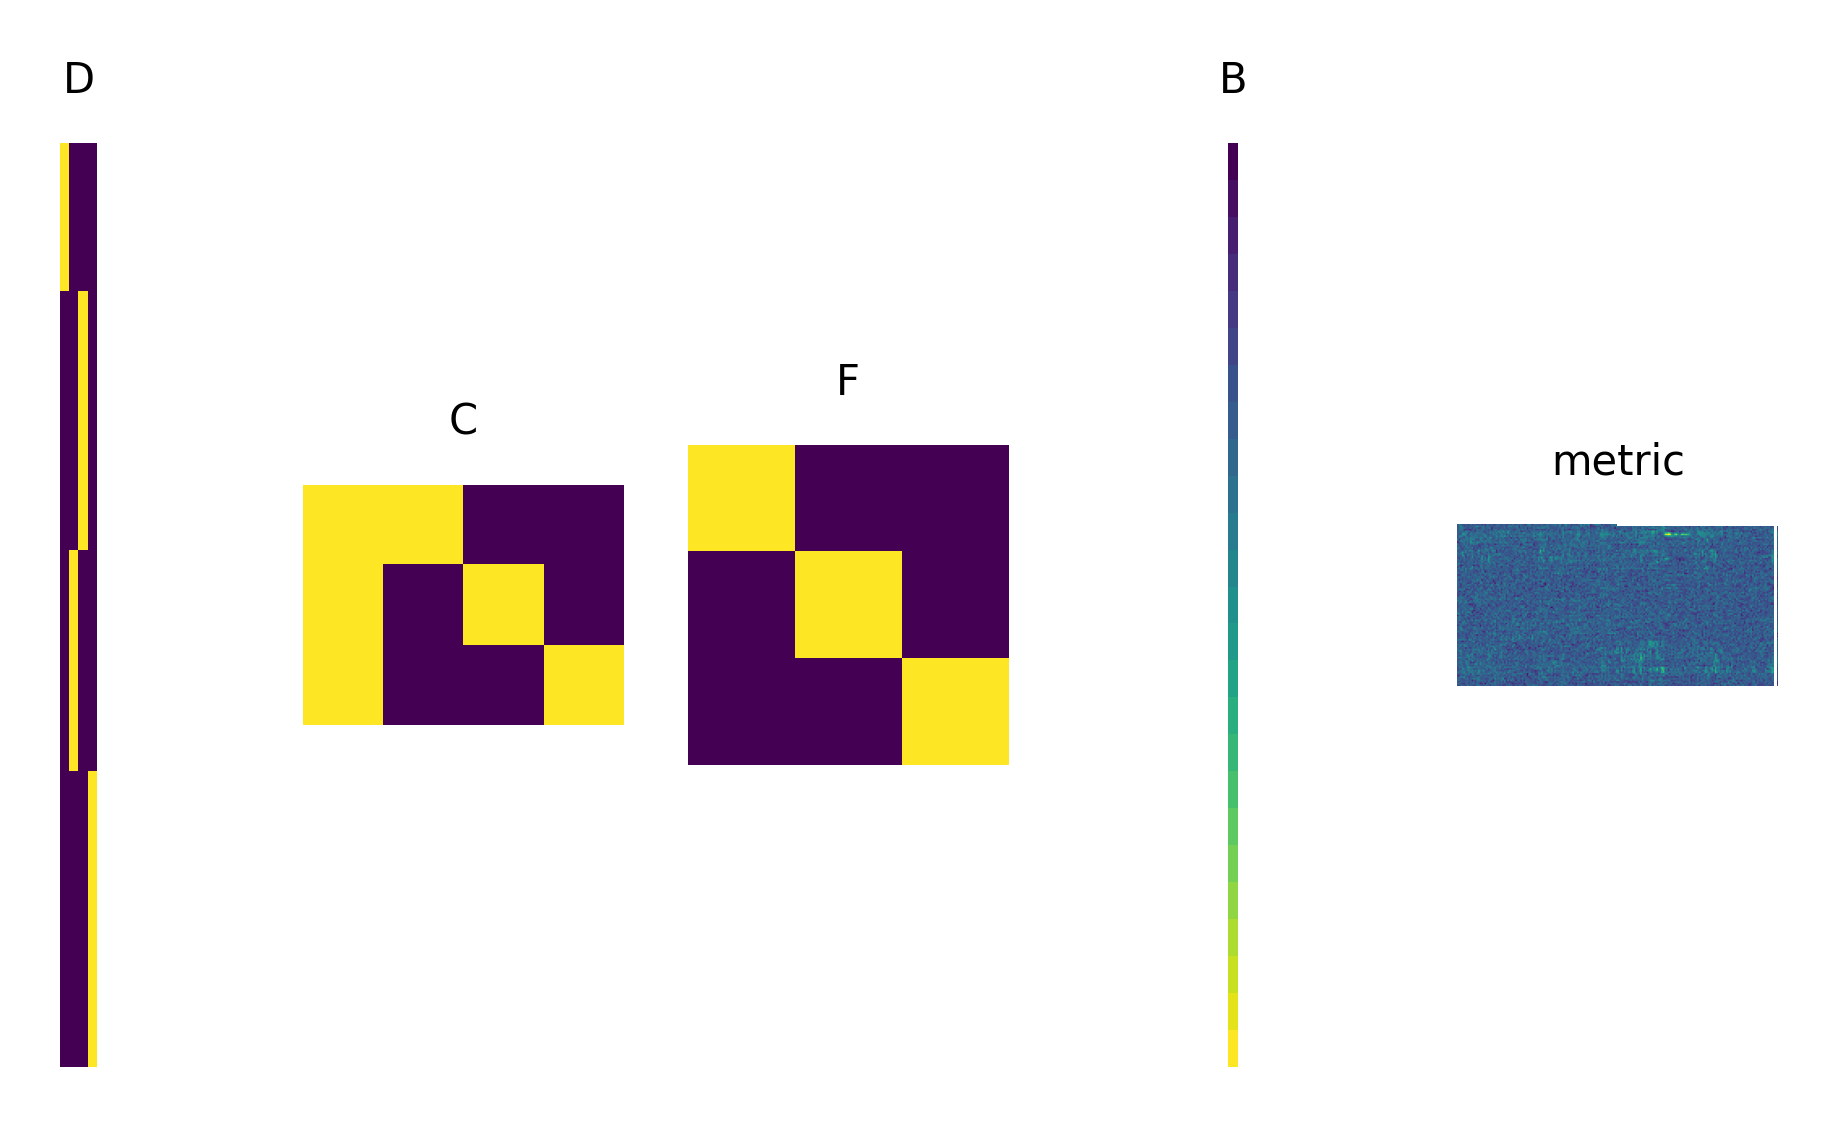

In [18]:
fig, ax_dict = plt.subplot_mosaic(
    [["D","C","F","B","metric"]],
    figsize=(4,2),
    dpi=600
)
for (ax_key, ax), df in zip(ax_dict.items(), [design_df,contrast_df, F_df, block_df,metric_df]):
    ax.set_title(ax_key,fontsize=FONTSIZE)
    ax.imshow(df)
    ax.set_xticks([])
    ax.set_yticks([])
    for _spine in ["left","right","top","bottom"]:
        ax.spines[_spine].set_visible(False)

AssertionError: projects/ADPET/palm/2x2_rsfc/two_by_two_anova_dat_tstat_fdrp_c1.csv does not exist.

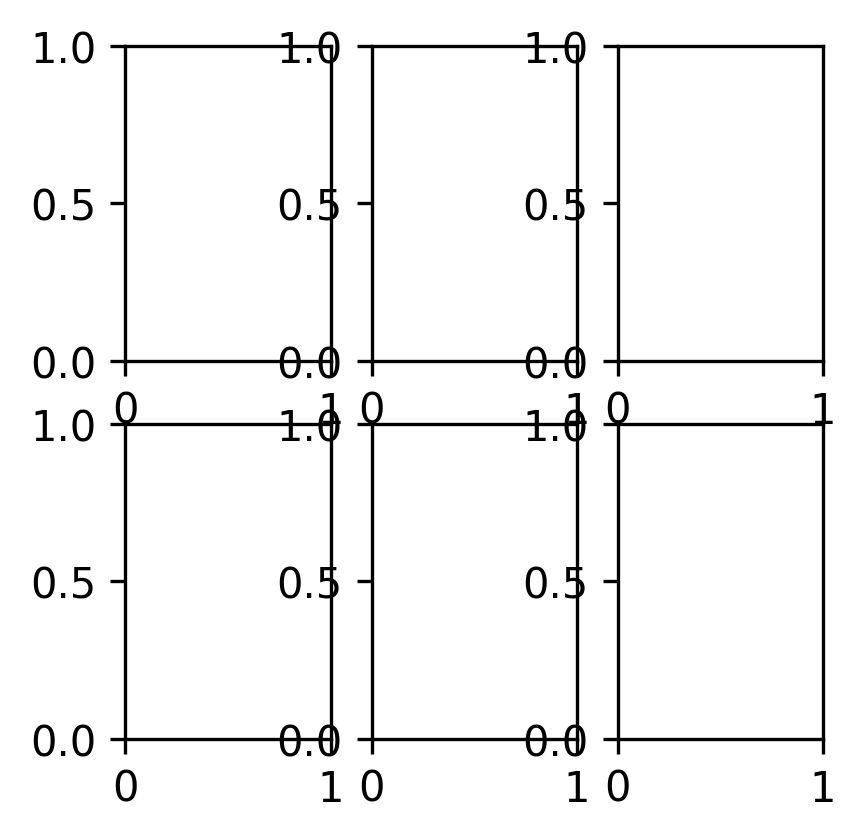

In [19]:
metric_type = "rsfc"
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3, 3), dpi=300)
contrast_mapping = {
    0: "MainAPOE",
    1: "MainKI",
    2: "Interaction"
}

for row_ix, p_suffix in enumerate(["fdrp","uncp"]):

    palm_csvs = [Path("projects") / "ADPET" / "palm" / f"2x2_{metric_type}" / f"two_by_two_anova_dat_tstat_{p_suffix}_c{i+1}.csv" for i in range(3)]
    for i in palm_csvs:
        assert i.exists(), f"{i} does not exist."
    roi_pairs_cols = [i for i in pd.read_csv(ROI_PAIRS_CSV, header=None)[0].values]

    for col_ix, palm_csv in enumerate(palm_csvs):

        ax = axs[row_ix, col_ix]

        palm_output = pd.read_csv(palm_csv, names = roi_pairs_cols).mean()
        conn = values2conn(palm_output, atlas_annots)
        """
        PLOT
        """

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(conn, dtype=bool)) + (conn<-np.log10(0.05))

        # Heatmap
        X = sns.heatmap(
            conn, 
            mask = mask, 
            cmap = 'magma', 
            square = True, 
            linewidths = 0, 
            cbar = None,
            vmin=-np.log10(0.05),
            ax=ax,
        )

        if row_ix == 0:
            ax.set_title(contrast_mapping[col_ix], fontsize=6)
        if col_ix == 0:
            ax.set_ylabel(p_suffix, fontsize=7)
        
        _ = X.set_xticks([])
        _ = X.set_yticks([])

fig.tight_layout()

In [21]:

def regionalpalmcsv2heatmap(palm_csvs, labels_cols):
    n_labels = len(labels_cols)
    n_contrasts = len(palm_csvs)
    heatmap = np.zeros((n_labels, n_contrasts))
    for ix, palm_csv in enumerate(palm_csvs):
        palm_output = pd.read_csv(palm_csv, names = labels_cols).mean()
        heatmap[:, ix] = palm_output.values
    
    return heatmap

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(4, 6),dpi=300)


for col_ix, metric_type in enumerate(['tsnr', 'alff', 'falff', 'ta_lag_1']):
    for row_ix, p_suffix in enumerate(["fdrp", "uncp"]):

        palm_csvs = [Path("projects") / "ADPET" / "palm" / f"2x2_{metric_type}" / f"two_by_two_anova_dat_tstat_{p_suffix}_c{i+1}.csv" for i in range(3)]
        for i in palm_csvs:
            assert i.exists()
        labels_cols = [i for i in pd.read_csv(LABELS_CSV, header=None)[0].values]
        heatmap = regionalpalmcsv2heatmap(palm_csvs, labels_cols)

        ax = axs[row_ix, col_ix]

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(heatmap, dtype=bool)) + (heatmap<-np.log10(0.05))
            
        # Heatmap
        X = sns.heatmap(
            heatmap, 
            mask = mask, 
            cmap = 'magma', 
            linewidths = 0, 
            cbar = None,
            vmin=-np.log10(0.05),
            ax=ax,
        )

        if row_ix == 0:
            ax.set_title(metric_type, fontsize=6)
        if col_ix == 0:
            ax.set_ylabel(p_suffix, fontsize=7)
        
        _ = X.set_yticks([])
        _ = X.set_xticks([i+.5 for i in range(3)])
        if row_ix == 1:
            _ = X.set_xticklabels([i for i in contrast_mapping.values()], fontsize=FONTSIZE, rotation=90)
        else:
            _ = X.set_xticklabels([' ' for i in range(3)], fontsize=FONTSIZE, rotation=90)

fig.tight_layout()

Metric dump

In [21]:
metric_dir = Path("projects/ADPET/metrics")
out_dir = Path("projects/ADPET/metrics_cleaned")
# single roi metric CSV
labels = pd.read_csv(metric_dir / "labels.csv",header=None)[0].values
sub_ids = pd.read_csv(metric_dir / "subjects.csv",header=None)[0].values
roi_pairs = pd.read_csv(metric_dir / "roi_pairs.csv",header=None)[0].values
for metric_name in ["ta_lag_1","tsnr", "alff", "falff"]:
    metric_df = pd.read_csv(metric_dir / f"{metric_name}.csv", header=None)
    metric_df.columns=labels
    metric_df.index=sub_ids
    out_csv = out_dir / f"{metric_name}.csv"
    metric_df.to_csv(out_csv)
# rsfc
rsfc_df = pd.read_csv(metric_dir / "rsfc.csv", header=None)
rsfc_df.columns=roi_pairs
rsfc_df.index=sub_ids
out_csv = out_dir / "rsfc.csv"
rsfc_df.to_csv(out_csv)
# denoise-config
out_json = out_dir / "denoising_config.json"
import json
with open(out_json, "w") as f:
    json.dump(str(denoise_settings), f, indent=4)

## STOP
TODO: voxelwise statistics

Voxelwise analysis of single-variate metrics

In [26]:
"""Voxelwise maps
"""
class brainmap:
    def __init__(self, bold_path: Path, TR) -> None:
        self.bold_path = bold_path
        self.bold_info = self._load_bold(bold_path)
        self.subject_info = self._get_info(bold_path)
        self.TR = TR

    def calculate_tsnr(self, deriv_dir: Path, save_nifti: bool=False):
        assert deriv_dir.is_dir(), f"{deriv_dir} is not a directory."
        sub_id, ses_id, run_id = self.subject_info.values()
        out_path = deriv_dir / f"sub-{sub_id}_ses-{ses_id}_run-{run_id}_tSNR.nii.gz"
        if out_path.exists():
            return nib.load(out_path).get_fdata()
        # if it does not exist then calculate
        bold_2d = self._reshape_bold_4d_to_2d()
        tsnr = bold_2d.mean(1) / bold_2d.std(1)
        nan_mask = np.isnan(tsnr)
        tsnr[nan_mask] = 0
        tsnr = self._reshape_metric_1d_to_3d(tsnr)
        if save_nifti:
            self._save_metric_as_nifti(tsnr, out_path)
            assert out_path.exists(), f"{out_path} was not generated."

        return tsnr

    def calculate_alff_falff_lag1ta(self, deriv_dir, save_nifti: bool=False):
        """Return tuple of np.ndarray corresponding to 
        alff, falff, and lag 1 temporal autocorrelation, 
        respectively
        """
        assert deriv_dir.is_dir(), f"{deriv_dir} is not a directory."
        sub_id, ses_id, run_id = self.subject_info.values()
        alff_out_path = deriv_dir / f"sub-{sub_id}_ses-{ses_id}_run-{run_id}_alff.nii.gz"
        falff_out_path = deriv_dir / f"sub-{sub_id}_ses-{ses_id}_run-{run_id}_falff.nii.gz"
        lag1ta_out_path = deriv_dir / f"sub-{sub_id}_ses-{ses_id}_run-{run_id}_lag1ta.nii.gz"
        if alff_out_path.exists() and falff_out_path.exists() and lag1ta_out_path.exists():
            return (
                nib.load(alff_out_path).get_fdata(),
                nib.load(falff_out_path).get_fdata(),
                nib.load(lag1ta_out_path).get_fdata(),
            )
        bold_2d = self._reshape_bold_4d_to_2d()
        n_voxels, n_tps = bold_2d.shape
        alff = np.zeros((n_voxels,))
        falff = np.zeros((n_voxels,))
        lag1ta = np.zeros((n_voxels,))
        for v in range(n_voxels):
            _alff, _falff = alff_and_falff(bold_2d[v,:], self.TR)
            _lag1ta = lag_1_ta(bold_2d[v,:])
            alff[v] = _alff
            falff[v] = _falff
            lag1ta[v] = _lag1ta

        metric_3ds = []
        for metric_type, metric_1d in zip(["alff", "falff", "lag1ta"], [alff, falff, lag1ta]):
            nan_mask = np.isnan(metric_1d)
            metric_1d[nan_mask] = 0
            metric_3d = self._reshape_metric_1d_to_3d(metric_1d)
            metric_3ds.append(metric_3d)
            if save_nifti:
                _out_path = deriv_dir / f"sub-{sub_id}_ses-{ses_id}_run-{run_id}_{metric_type}.nii.gz"
                self._save_metric_as_nifti(metric_3d, _out_path)
                assert _out_path.exists(), f"{_out_path} was not generated"

        return tuple(metric_3ds)


    def _reshape_bold_4d_to_2d(self):
        data = self.bold_info['data'].copy()
        flattened_data = data.reshape(-1, data.shape[3])

        return flattened_data

    def _reshape_metric_1d_to_3d(self, metric: np.ndarray):
        """Metric is 1d
        """
        metric_3d = metric.reshape(self.bold_info['3dshape'])

        return metric_3d

    def _save_metric_as_nifti(self, metric: np.ndarray, out_path: Path) -> None:
        img = nib.Nifti1Image(
            metric, affine = self.bold_info["affine"], header = self.bold_info["header"]
        )
        nib.save(img, out_path)
    
    def _load_bold(self, bold_path: Path):
        img = nib.load(bold_path)
        assert len(img.shape) == 4
        bold_info = {
            "data": img.get_fdata(),
            "3dshape": img.shape[:-1],
            "affine": img.affine,
            "header": img.header,
        }

        return bold_info

    def _strip_identifier(self, _str: str, identifier: str) -> str:
        return _str.split(identifier)[1].split('_')[0]

    def _get_info(self, bold_path: Path) -> Dict:
        info = {
            "sub_id": self._strip_identifier(str(bold_path.stem), "sub-"),
            "ses_id": self._strip_identifier(str(bold_path.stem), "ses-"),
            "run_id": self._strip_identifier(str(bold_path.stem), "run-"),
        }
        return info


In [ ]:
nifti_brainmaps_dir = Path("projects/ADPET/brainmaps_nifti")
nifti_group_brainmaps_dir = Path("projects/ADPET/group_brainmaps_nifti")
cifti_brainmaps_dir = Path("projects/ADPET/brainmaps_cifti")
for _dir in [nifti_brainmaps_dir, cifti_brainmaps_dir]:
    if not _dir.exists():
        _dir.mkdir(parents=True)

bolds

In [ ]:
TR = 1.5
for _bold in bolds:
    dh = brainmap(Path(_bold),TR)
    sub_id, ses_id, run_id = dh.subject_info.values()
    tsnr = dh.calculate_tsnr(nifti_brainmaps_dir, save_nifti=True)
    alff,falff,lag1ta = dh.calculate_alff_falff_lag1ta(nifti_brainmaps_dir, save_nifti=True)


ICA

In [ ]:
atlas_mask = Path("projects/ADPET/mask.nii.gz"); assert atlas_mask.exists()
comma_separated_bold_paths = ','.join([str(i) for i in bolds])
n_ica_dimensions = 30

melodic_outdir = nifti_group_brainmaps_dir / f"dim-{n_ica_dimensions}_groupICA"
if not melodic_outdir.exists():
    !melodic -i {comma_separated_bold_paths} \
        -o {melodic_outdir} \
        -m {atlas_mask} \
        -d {n_ica_dimensions} \
        --Oall --verbose
else:
    print(f"{melodic_outdir} already ran.")

In [ ]:
melodic_outdir